# ST445 Managing and Visualizing Data
## Model Evaluation
### Milan Vojnovic and Christine Yuen, MT 2017
---

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

## Preparation

### Loading libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

# libraries for model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score

# libraries for model fitting
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### Loading data

In [3]:
# import data
voice = pd.read_csv("voice.csv")
y = voice.label=='male'
X = voice.drop(['label'], axis=1)

### Helper functions

In [11]:
def plot_roc_helper(ax, y_test, pred_prob, name):
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1, label= name + ' (area = %0.3f)' % roc_auc)

def plot_roc(ax, y_test, pred_prob, y_test_inflated, pred_prob_inflated):
    plot_roc_helper(ax, y_test, pred_prob, "original")
    plot_roc_helper(ax, y_test_inflated, pred_prob_inflated, "inflated")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9)
    
def plot_pr_helper(ax, y_test, pred_prob, name):
    # pr curve
    precision, recall, _ = precision_recall_curve(y_test,pred_prob)
    avg_precision = average_precision_score(y_test, pred_prob)
    ax.plot(recall, precision, lw=1);
    
def plot_pr(ax, y_test, pred_prob, y_test_inflated, pred_prob_inflated):
    plot_pr_helper(ax, y_test, pred_prob, "original")
    plot_pr_helper(ax, y_test_inflated, pred_prob_inflated, "inflated")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9)

def inflate_samples(X, y, inflation):
    i1 = np.where(y==0)[0]
    i2 = np.where(y==1)[0]
    i = np.concatenate([np.random.choice(i2,len(i2)*inflation), i1, i2])
    X_inflated = X.reset_index().drop('index', axis=1).iloc[i]
    y_inflated = y.reset_index().label[i]
    return X_inflated, y_inflated


def plot_effect_of_inflation(X, y, inflations, is_train_set_inflated, is_test_set_inflated, title):
    plt.clf()
    fig = plt.figure(figsize=(8,16))

    for j in range(0,len(inflations)):
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)

        # inflate data
        X_train_inflated, X_test_inflated, y_train_inflated, y_test_inflated = X_train, X_test, y_train, y_test
        if is_train_set_inflated:
            X_train_inflated, y_train_inflated = inflate_samples(X_train, y_train, inflations[j])
        if is_test_set_inflated:
            X_test_inflated, y_test_inflated = inflate_samples(X_test, y_test, inflations[j])

        # fit
        classifier = LogisticRegression(C=1., solver='lbfgs')
        classifier.fit(X_train,y_train)
        classifier_inflated = LogisticRegression(C=1., solver='lbfgs')
        classifier_inflated.fit(X_train_inflated,y_train_inflated)

        # predict
        pred_prob = classifier.predict_proba(X_test)[:,1]
        pred_prob_inflated = classifier_inflated.predict_proba(X_test_inflated)[:,1]

        # plot
        ax1 = fig.add_subplot(len(inflations), 2, 2*j+1)
        ax2 = fig.add_subplot(len(inflations), 2, 2*j+2)
        plot_roc(ax1, y_test, pred_prob, y_test_inflated, pred_prob_inflated)
        plot_pr(ax2, y_test, pred_prob, y_test_inflated, pred_prob_inflated)
        
    fig.suptitle(title, size=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show(); 
    
def plot_effect_of_inflation_before_splitting(X, y, inflations, title):
    plt.clf()
    fig = plt.figure(figsize=(8,16))

    for j in range(0,len(inflations)):
        # split data
        X_inflated, y_inflated = inflate_samples(X, y, inflations[j])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
        X_train_inflated, X_test_inflated, y_train_inflated, y_test_inflated = train_test_split(X_inflated, y_inflated, test_size=.5)

        # fit
        classifier = LogisticRegression(C=1., solver='lbfgs')
        classifier.fit(X_train,y_train)
        classifier_inflated = LogisticRegression(C=1., solver='lbfgs')
        classifier_inflated.fit(X_train_inflated,y_train_inflated)

        # predict
        pred_prob = classifier.predict_proba(X_test)[:,1]
        pred_prob_inflated = classifier_inflated.predict_proba(X_test_inflated)[:,1]

        # plot
        ax1 = fig.add_subplot(len(inflations), 2, 2*j+1)
        ax2 = fig.add_subplot(len(inflations), 2, 2*j+2)
        plot_roc(ax1, y_test, pred_prob, y_test_inflated, pred_prob_inflated)
        plot_pr(ax2, y_test, pred_prob, y_test_inflated, pred_prob_inflated)
        
    fig.suptitle(title, size=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show(); 

In [12]:
np.random.seed(100)
inflations = (1,2,5,10)

1\. Split the data 50%-50% into train and test components. Fit the logistic regression using the train data. Let $P$ denote the number of positive examples in the test data. Sample $P$ examples by sampling uniformly at random _with replacement_ from the set of test positive examples. Combine these samples with the original test data to create a _modified test data_. Show two plots: one containing ROC curves for original and modified test data and the other containing precision-recall curves for original and modified test data. Repeat the same three times for the number of randomly sampled examples equal to $2P$, $5P$ and $10P$, respectively. Discuss the results.


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


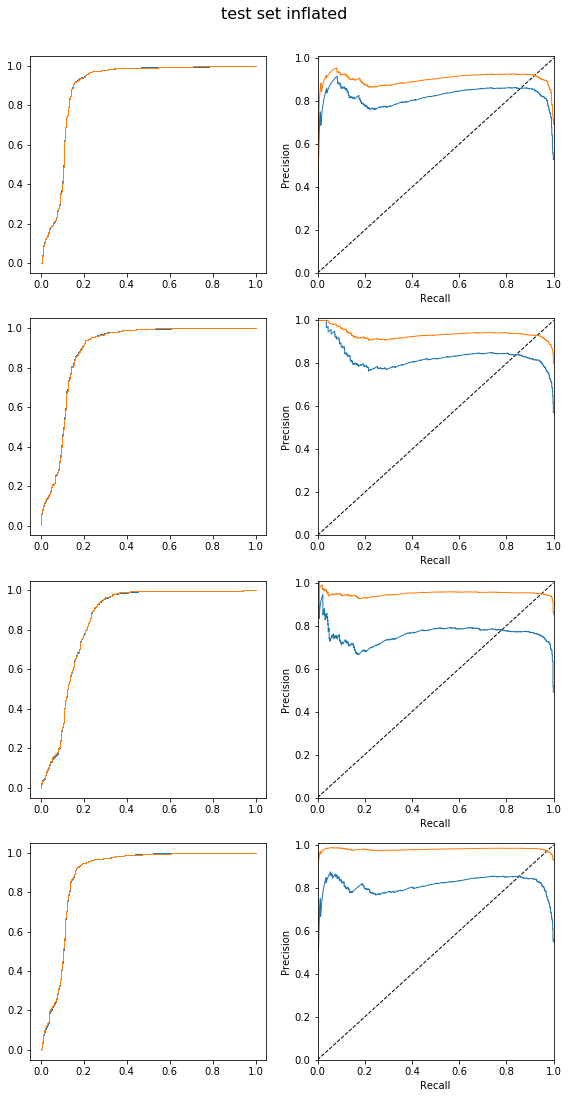

In [14]:
plot_effect_of_inflation(X, y, inflations, False, True, "test set inflated");

2\. Do the same as in item 1 but for the cases when using modified data, first apply the data modification procedure to the _whole_ input data (with $P$ redefined to be the number of positive examples in the input data), and then split the modified data 50%-50% into train and test components, and fit the logistic regression model using the train data. Discuss the results.

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


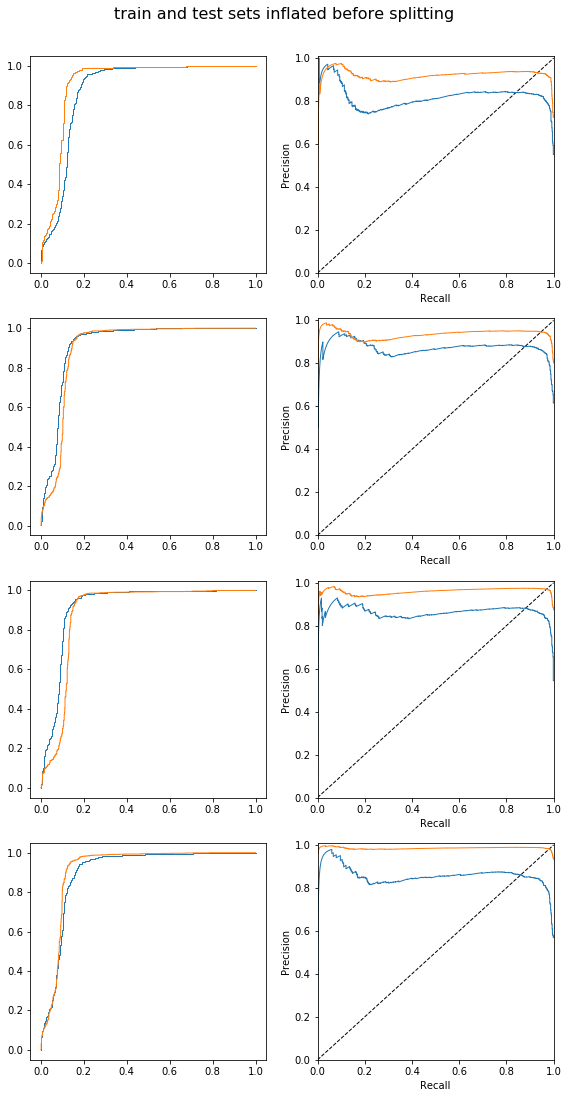

In [15]:
plot_effect_of_inflation_before_splitting(X, y, inflations, "train and test sets inflated before splitting")